In [1]:
from libs.dinov2_latent_generator import DinoV2latentGen
model_cfg = {
    'name': 'dinov2_vitb14',
    'struct': 'dinov2/',
    'path': 'dinov2_vitb14_pretrain.pth',
}

latentGenerator = DinoV2latentGen(model_cfg, 'mps')
latent_dim = latentGenerator.model.embed_dim


/Users/raiso/mask_export_center_area/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/raiso/mask_export_center_area/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/raiso/mask_export_center_area/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Device:  mps


In [2]:
from libs.video_analysis import VideoAnalyzer
import gradio as gr

objects = [
    [152, 210, 74], #{"R": 152, "G": 210, "B":74},
]
analyzer = VideoAnalyzer(objects)

results = analyzer.process_video("test/S37_mask.mp4", gr.Progress())

/Users/raiso/mask_export_center_area/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


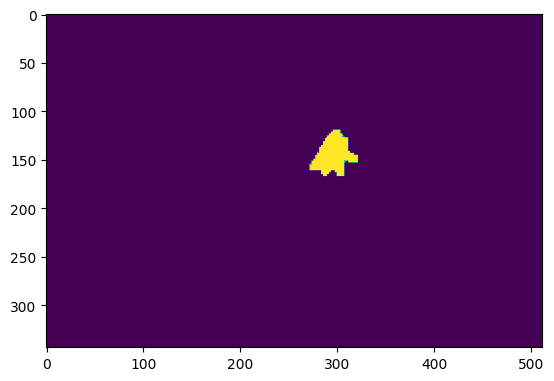

In [9]:
import matplotlib.pyplot as plt
for it in results:
    plt.imshow(results[it].labels[0])
    break

In [39]:
import torchvision.transforms as tt
resolution = 518
img2tensor = tt.Compose([
    tt.ToTensor(), # range [0, 255] -> [0.0,1.0]
    tt.Resize((resolution, resolution), antialias=True),
    tt.Normalize(mean=0.5, std=0.2), # range [0.0,1.0] -> [-2.5, 2.5]
])

img2mask = tt.Compose([
    tt.ToTensor(), # range [0, 255] -> [0.0,1.0]
    tt.Resize((resolution, resolution), antialias=True),
])

In [95]:
from tqdm import tqdm
import cv2

vin = "test/S37_fv.avi"
cap = cv2.VideoCapture(vin)
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
latents = []

for i in tqdm(range(n)):
    ok, image = cap.read()
    assert ok, "[E] Video Reading Error"
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor = img2tensor(image)
    latent = latentGenerator.single_run(tensor)
    latent = latent.reshape((37, 37, latent_dim))
    small_mask = np.zeros((37, 37))
    small_mask = tmask[0].reshape(resolution//14, 14, resolution//14, 14).sum(axis=(1, 3))
    sum_mask = small_mask.sum()
    result = small_mask[:, :, np.newaxis] * latent
    latent_mask_ave = result.sum(axis=0).sum(axis=0) / sum_mask
    latents.append(latent_mask_ave)

    if i == 5:
        break

cap.release()
latents = np.array(latents)


  0%|          | 5/9600 [00:03<1:48:45,  1.47it/s]


In [96]:
latents.shape

(6, 768)

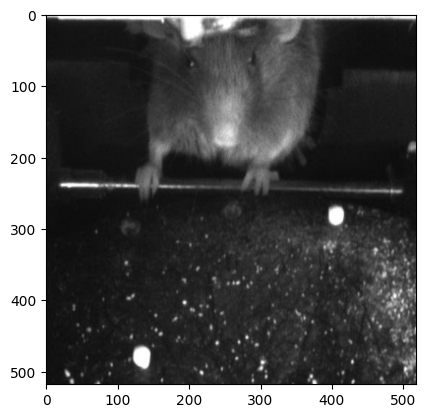

In [22]:
import torch
plt.imshow(torch.mean(tensor, axis=0), cmap='gray'

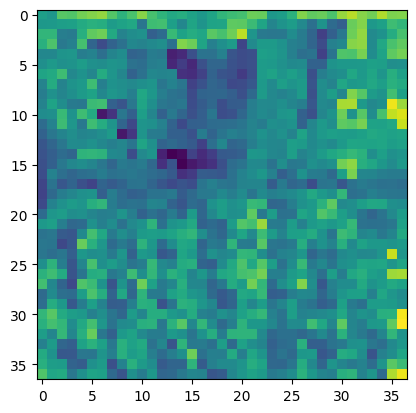

In [28]:
plt.imshow(latent[:, :, 0])

In [29]:
results[it].labels[0].shape

(344, 512)

In [33]:
import numpy as np
mask = np.array(results[it].labels[0], dtype=float)

In [38]:
tt.ToTensor()

TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given

In [41]:
tmask = img2mask(mask)

In [58]:
resolution // 14

37

torch.Size([37, 37, 768])


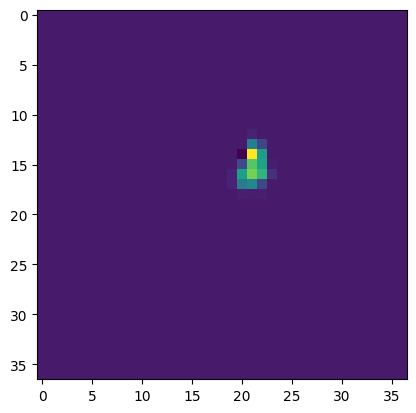

In [79]:
result = small_mask[:, :, np.newaxis] * latent
result.sum(axis=0).sum(axis=0)
print(result.shape)
plt.imshow(result[:, :, :3])